# Building a Weighted Hybrid Recommender

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, ndcg_score
from sklearn.pipeline import Pipeline
RANDOM_STATE = 18
import joblib

### Creating Data Sets

In [23]:
# Import Data
df = pd.read_csv('data/ratings.csv')
features = pd.read_csv('data/data_content_based_v1.csv', index_col=0)

# Select only features that we found were relevant
features.drop(['rating','ratings2','sample_ratings','outlier','title','zip_code','place_name'], 1, inplace=True)

# Create train and test in Surprise fashion
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

# Use surprise train and test split to build dataset for content based with features (important to keep the same split)
train = pd.DataFrame(trainset.all_ratings(), columns=['userId', 'movieId', 'rating'])
test = pd.DataFrame(testset, columns=['userId', 'movieId', 'rating'])

# Transfrom inner IDs back to actual IDs
train['userId'] = [trainset.to_raw_uid(i) for i in train.userId]
train['movieId'] = [trainset.to_raw_iid(i) for i in train.movieId]

# Merge features to trainset for content based
train_withId = train
test_withId = test
X_train = train.merge(features, how='left', on=['userId','movieId']).drop(['userId','movieId','rating'],1)
X_test = test.merge(features, how='left', on=['userId','movieId']).drop(['userId','movieId','rating'],1)

y_train = pd.DataFrame(trainset.all_ratings(), columns=['userId', 'movieId', 'rating'])['rating']
y_test = pd.DataFrame(testset, columns=['userId', 'movieId', 'rating'])['rating']

C:\Users\leofr\AppData\Local\Temp/ipykernel_14908/1407154820.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features.drop(['rating','ratings2','sample_ratings','outlier','title','zip_code','place_name'], 1, inplace=True)
C:\Users\leofr\AppData\Local\Temp/ipykernel_14908/1407154820.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train.merge(features, how='left', on=['userId','movieId']).drop(['userId','movieId','rating'],1)
C:\Users\leofr\AppData\Local\Temp/ipykernel_14908/1407154820.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = test.merge(features, how='left', on=['userId','movieId']).drop(['userId','movieId','rating'],1)


### Popularity

In [60]:
def popularity(n, train_withId):
    pop_data = train_withId.groupby('movieId').rating.agg(['sum','mean'])
    top_n_movies = pop_data['sum'].nlargest(n).index
    result = pd.DataFrame({'movieId':top_n_movies}).merge(pop_data, on='movieId', how='inner')[['movieId','mean']]
    result['mean'] = round(result['mean'], 2)
    result.columns = ['movieId','pred_rating']
    return result.reset_index(drop=True)

pred_pop = popularity(len(np.unique(train_withId.movieId)),train_withId)

In [61]:
pred_pop

,movieId,pred_rating
0,318,4.42
1,296,4.23
2,356,4.16
3,2571,4.19
4,593,4.18
...,...,...
8959,95796,0.50
8960,53453,0.50
8961,54768,0.50
8962,5105,0.50


In [63]:
pop_result = test_withId.merge(pred_pop, on='movieId', how='inner')[['rating','pred_rating']]

In [64]:
np.sqrt(mean_squared_error(pop_result.rating,pop_result.pred_rating))

0.9701801664256746

### Best Tuned Collaborative Filtering Model (SVD)

In [79]:
svd_params = {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

svd_model = SVD(
    n_factors=svd_params['n_factors'],
    n_epochs=svd_params['n_epochs'],
    lr_all=svd_params['lr_all'],
    reg_all=svd_params['reg_all']
    )
    
svd = svd_model.fit(trainset)

In [81]:
joblib.dump(svd, 'svd_model.pkl')

['svd_model.pkl']

### Best Tuned Content-Based Model (Random Forest Regressor) 

In [98]:
rf_params = {'n_estimators':110,'max_features':'auto','min_samples_split':24,'max_depth':26}

rf_model = RandomForestRegressor(
    n_estimators=rf_params['n_estimators'],
    max_features=rf_params['max_features'],
    min_samples_split=rf_params['min_samples_split'],
    max_depth=rf_params['max_depth'],
    n_jobs=-1
    )

numVars = X_train.select_dtypes(include='number').columns.tolist()
catVars = X_train.select_dtypes(exclude='number').columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
preprocess = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numVars),
    ('category', categorical_pipeline, catVars)
])
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf_model)
])

rf_pipe = rf_pipe.fit(X_train, y_train)

In [107]:
joblib.dump(rf_pipe, 'rf_pipe_model_best.pkl')

['rf_pipe_model_best.pkl']

In [84]:
rf_params = {'rf__n_estimators': np.arange(50,150,10),
             'rf__max_features': ['sqrt', 'auto', 'log2'],
             'rf__min_samples_split': np.arange(2, 40, 2),
             'rf__max_depth': np.arange(4, 30, 2)}

rf_search = RandomizedSearchCV(rf_pipe, rf_params, cv=5, scoring = 'neg_root_mean_squared_error', n_iter=20, n_jobs=-1, verbose=2)

rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('number',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['year',
                                                                                'Action',
                                                                                'Adventure',
                                                                                'Animation',
                    

In [85]:
rf_search.best_params_

{'rf__n_estimators': 110,
 'rf__min_samples_split': 24,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 26}

### Evaluating Individual Models

In [99]:
pred_cf = pd.DataFrame(svd_model.test(testset)).est
pred_cb = rf_pipe.predict(X_test)

In [100]:
result = pd.Series([np.sqrt(mean_squared_error(y_test,pred_cf)),np.sqrt(mean_squared_error(y_test, pred_cb))], 
                  index = ['Collaborative Filtering','Content-Based'])
result

Collaborative Filtering    0.856962
Content-Based              0.888943
dtype: float64

### Combining Predictions

Best Value: [0.65, 0.8450247185239582]


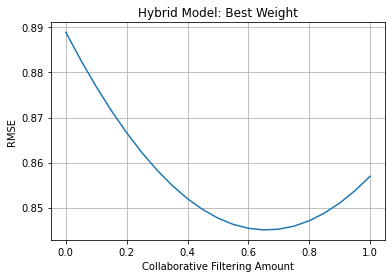

In [112]:
val = []
w = np.linspace(0,1,21)

for i in w:
    pred = pred_cf*i + pred_cb*(1-i)
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    val.append([i, rmse])
print('Best Value:', min(val, key=lambda x: x[1]))
val_np = np.array(val)
plt.plot(val_np[:, 0], val_np[:,1])
plt.title('Hybrid Model: Best Weight')
plt.xlabel('Collaborative Filtering Amount')
plt.ylabel('RMSE')
plt.grid();

In [102]:
best_weight = 0.65
final_prediction = (best_weight*pd.DataFrame(svd_model.test(testset)).est) + ((1-best_weight)*rf_pipe.predict(X_test))
result['Hybrid Approach'] = np.sqrt(mean_squared_error(final_prediction,y_test))

### Final RMSE Scores

In [103]:
pd.DataFrame(result, columns=['RMSE'])

,RMSE
Collaborative Filtering,0.856962
Content-Based,0.888943
Hybrid Approach,0.845025


### Evaluating Ranking at k using nDCG

In [174]:
def discountedCumulativeGain(result):
    dcg = []
    for idx, val in enumerate(result): 
        numerator = 2**val - 1
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
        score = numerator/denominator
        dcg.append(score)
    return sum(dcg)

def normalizedDiscountedCumulativeGain(result, sorted_result): 
    dcg = discountedCumulativeGain(result)
    idcg = discountedCumulativeGain(sorted_result)
    ndcg = dcg / idcg
    return ndcg

In [185]:
def calculate_ndcg_score(pred_order, actual_order, k):
        ndcg_scores = []
        for user in true_ratings.userId.unique():
            pred = pred_order[pred_order.userId==user].rating[:k]
            true = actual_order[actual_order.userId==user].rating[:k]
            ndcg_scores.append(normalizedDiscountedCumulativeGain(pred, true))
        return np.mean(ndcg_scores)

#### Hybrid Model

In [180]:
true_ratings = pd.DataFrame(testset, columns=['userId', 'movieId', 'rating'])
pred_ratings = pd.DataFrame({'userId':true_ratings.userId,'movieId':true_ratings.movieId,'pred_rating':final_prediction})
hybrid_ratings = pred_ratings.merge(true_ratings, on=['movieId','userId'])
pred_order = hybrid_ratings.sort_values('pred_rating', ascending=False)
actual_order = hybrid_ratings.sort_values('rating', ascending=False)

In [228]:
print('NDCG@k Hybrid Model')
hybrid_results = []
for k in range(1,6):
    hybrid_results.append(calculate_ndcg_score(pred_order, actual_order, k=k))
    print('k:',k, 'ndcg:',calculate_ndcg_score(pred_order, actual_order, k=k))

NDCG@k Hybrid Model
k: 1 ndcg: 0.732354876558595
k: 2 ndcg: 0.7394806417655831
k: 3 ndcg: 0.7508238615955036
k: 4 ndcg: 0.7653912915153064
k: 5 ndcg: 0.7778344855777376


#### Collaborative Filtering

In [200]:
cf_pred_ratings = pd.DataFrame({'userId':true_ratings.userId,'movieId':true_ratings.movieId,'pred_rating':pred_cf})
cf_ratings = cf_pred_ratings.merge(true_ratings, on=['movieId','userId'])
cf_pred_order = cf_ratings.sort_values('pred_rating', ascending=False)
cf_actual_order = cf_ratings.sort_values('rating', ascending=False)

In [206]:
print('NDCG@k Collaborative Filtering Model')
cf_results = []
for k in range(1,6):
    cf_results.append(calculate_ndcg_score(cf_pred_order, cf_actual_order, k=k))
    print('k:',k, 'ndcg:',calculate_ndcg_score(cf_pred_order, cf_actual_order, k=k))

NDCG@k Collaborative Filtering Model
k: 1 ndcg: 0.7173580048012108
k: 2 ndcg: 0.724019996821187
k: 3 ndcg: 0.7358893216439661
k: 4 ndcg: 0.7524130522462806
k: 5 ndcg: 0.765719013783001


#### Content-Based

In [203]:
cb_pred_ratings = pd.DataFrame({'userId':true_ratings.userId,'movieId':true_ratings.movieId,'pred_rating':pred_cb})
cb_ratings = cb_pred_ratings.merge(true_ratings, on=['movieId','userId'])
cb_pred_order = cb_ratings.sort_values('pred_rating', ascending=False)
cb_actual_order = cb_ratings.sort_values('rating', ascending=False)

In [205]:
print('NDCG@k Collaborative Filtering Model')
cb_results = []
for k in range(1,6):
    cb_results.append(calculate_ndcg_score(cb_pred_order, cb_actual_order, k=k))
    print('k:',k, 'ndcg:',calculate_ndcg_score(cb_pred_order, cb_actual_order, k=k))

NDCG@k Collaborative Filtering Model
k: 1 ndcg: 0.6574687315720641
k: 2 ndcg: 0.686633840075842
k: 3 ndcg: 0.7060664070691977
k: 4 ndcg: 0.7263465168584994
k: 5 ndcg: 0.7402979580686991


#### Visualization

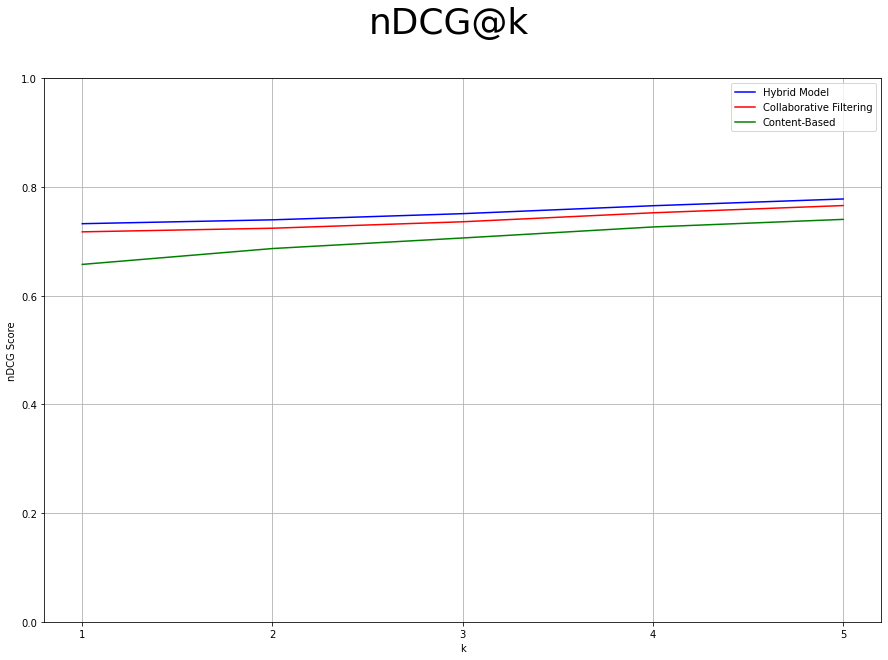

In [241]:
x = np.arange(1,6)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(x,hybrid_results,'b',label='Hybrid Model')
plt.plot(x,cf_results,'r',label='Collaborative Filtering')
plt.plot(x,cb_results,'g',label='Content-Based')
plt.xlabel('k')
plt.ylabel('nDCG Score')
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.xticks([1,2,3,4,5])
fig.suptitle('nDCG@k', fontsize=36);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=62a140d2-916c-455c-a3c7-f55a270ae371' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>